This notebook: 

transformational efficacy analysis (TVI computations) for context (location of the sample - above fixation 'up' vs below fixation 'down')


In [1]:
!pip install dpca

In [2]:
#cd /content/gdrive/My Drive/dpca_code_V2
#from pumi import * 
#from fit_scaling import *
#import dpca as dp
#import plotting as pf
#import matplotlib.pyplot as plt
#from google.colab import files
#from scipy import io
#from scipy import stats

import numpy as np
import io
import pandas as pd
import matplotlib.pyplot as plt
from pumi import *
from fit_scaling import *
import dpca as dp
import plotting_updown_ver2 as pf
from scipy import io
from scipy import stats
import scipy.io as sio
import math


[3.8339550004891927, 2.72106346825007, 4.950188403418709, 6.626647769152757, 4.386492549649054, 4.070340390518182, 3.9221791347021386, 5.241468647538477, 6.868041132393812, 2.993710074398114, 3.294524905016069, 4.434065765328412]
[4.97394276959601, 4.492902086491397, 4.962340950216685, 4.438714090641431, 2.7206064669595387, 4.015662170963713, 4.449431332832543, 4.374586224575451, 8.748860627330995, 2.565844093164607, 2.5345562804372666, 4.473661017111667]
[4.948846872645775, 2.311015382832668, 5.591899419832759, 15.037541503228285, 5.286285192615482, 4.121837625393048, 4.227488887048606, 2.8204456412559855, 4.935203838993839, 3.9205198125776617, 3.1226483536929504, 3.7753018456560943]
[4.632503761312934, 2.7665387137272233, 5.07358103649666, 11.672277705866993, 5.598881020066052, 2.3187473147964597, 5.180959551041254, 2.100856448176248, 4.94558592761952, 4.989387984815538, 3.5288664798445657, 3.307049173780636]
[3.529874689761023, 2.923983467572044, 5.353847613139372, 6.881409586426363

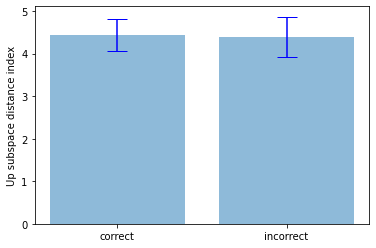

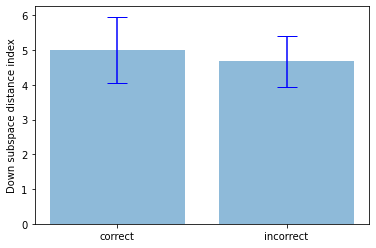

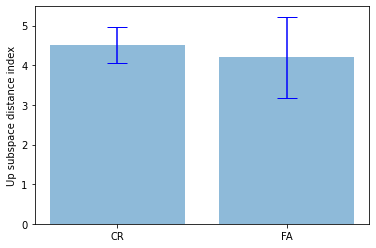

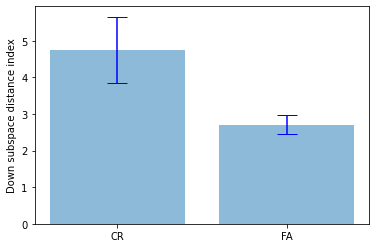

In [4]:
# First does 'Up' (above fixation) subspace analysis, Then does 'Down' (below fixation) subspace analysis

num_sub = 12
sub_FA_up = []
sub_CR_up = []
sub_FA_down = []
sub_CR_down = []
sub_corr_up = []
sub_incorr_up = []
sub_corr_down = []
sub_incorr_down = []
sub_up = []
sub_down = []
sub_correlation = []
sub_r = []
sub_p = []
sub_corr_r = []
sub_corr_p = []
sub_incorr_r = []
sub_incorr_p = []

for subject_id in range(num_sub):

    # first load average data for each stimulus condition to do dPCA and derive subspaces
    sub_id = str(subject_id+1)
    filename='[PATH TO DATA DIRECTORY]/DSR_contextversion/S' + sub_id + 'allfulltimecoursecontext.mat'
    matdata = sio.loadmat(filename)

    data_up=matdata['avgdataup'] # 3 rows (dimension 1): face up, word up, dots up
    data_tmp=data_up[:,100:351,:] # 'up' subspace model - using timepoints from Delay 1.1
    data_tmp=center(data_tmp)

    data_down=matdata['avgdatadown'] #3 rows: face down, word down, dots down
  

    cat_model = dp.dPCA(data_tmp, n_dim = 2, old_version=True)
    d = cat_model.decoder
    Xup = np.matmul(center(data_up),d) # project data into 'up' subspace
    Xdown = np.matmul(center(data_down),d) 
    
    xyup = Xup[:,100:351,:].mean(1)
    xydown = Xdown[:,100:351,:].mean(1)
    
    # compute 'general' (Euclidean) distances between 'up' and 'down' in the 'up' subspace for each of the three stim categories
    normdist1 = math.sqrt(((xyup[0,0]-xydown[0,0])**2)+((xyup[0,1]-xydown[0,1])**2))
    normdist2 = math.sqrt(((xyup[1,0]-xydown[1,0])**2)+((xyup[1,1]-xydown[1,1])**2))
    normdist3 = math.sqrt(((xyup[2,0]-xydown[2,0])**2)+((xyup[2,1]-xydown[2,1])**2))

    # now load individual trial data
    filename='[PATH TO DATA DIRECTORY]/DSR_trialinfo/trinfo_S_0' + sub_id + '_2D.mat'
    matdata = sio.loadmat(filename)
    trinfo=matdata['trialinfo'] # individual trial info

    filename='[PATH TO DATA DIRECTORY]/DSR_alltrials/S' + sub_id + 'alltrials.mat'
    matdata = sio.loadmat(filename)
    alldata=matdata['data'] # individual trial data

    Xindivtrials = np.matmul(center(alldata),d) # project individual trial data into 'up' subspace
    num_trials = len(Xindivtrials)
   
    trdist = []
    trnormdist = []
    FA = []
    CR = []
    correct = []
    incorrect = []

    # calculate for only 'up' stimuli - because this will be 'up' distances in 'up' subspace
    # first calculate the distance between the individual trial's projection in the 'up' space and 
    # the 'general' representation in 'up' subspace for that stimulus category
    # then, normalize that by the general distances computed above
    for tr in range(num_trials): 
        xytrial = Xindivtrials[tr,100:351,:].mean(0) 
        if trinfo[tr,2] == 1 or trinfo[tr,2] == 2: # face was up
            trdist += [math.sqrt(((xytrial[0]-xyup[0,0])**2)+((xytrial[1]-xyup[0,1])**2))]
            trnormdist += [trdist[-1] / normdist1]
        elif trinfo[tr,2] == 3 or trinfo[tr,2] == 4: # motion was up
            trdist += [math.sqrt(((xytrial[0]-xyup[2,0])**2)+((xytrial[1]-xyup[2,1])**2))]
            trnormdist += [trdist[-1] / normdist3]
        elif trinfo[tr,2] == 5 or trinfo[tr,2] == 6: # word was up
            trdist += [math.sqrt(((xytrial[0]-xyup[1,0])**2)+((xytrial[1]-xyup[1,1])**2))]
            trnormdist += [trdist[-1] / normdist2]
    
    # for the trial splits by accuracy/performance/trial type, go ahead and divvy up here accordingly           
    for tr in range(num_trials):
        if trinfo[tr,3] == trinfo[tr,5]: # stay trial for probe 2 analysis
            if trinfo[tr,14] == 1: # lure probe trial; 14- probe 1; 15 - probe 2 - SWITCH TO 15 FOR PROBE 2 ANALYSIS
                if trinfo[tr,7] == 1: # CR - index is #7 for Probe 1 responses; #9 for Probe 2 - SWITCH TO 9 FOR PROBE 2 ANALYSIS
                    CR += [trnormdist[tr]]
                elif trinfo[tr,7] == -1: # FA - SWITCH TO 9 FOR PROBE 2 ANALYSIS
                    FA += [trnormdist[tr]]
      
            if trinfo[tr,7] == 1: # CR/hit - SWITCH TO 9 FOR PROBE 2 ANALYSIS
                correct += [trnormdist[tr]]
            elif trinfo[tr,7] == -1: # FA/miss - SWITCH TO 9 FOR PROBE 2 ANALYSIS
                incorrect += [trnormdist[tr]]

    # now do some averaging and compiling for between-subjects and within-subjects analyses
    tmpcr = np.array(CR) 
    tmpfa = np.array(FA)
    sub_CR_up += [np.mean(tmpcr)] 
    sub_FA_up += [np.mean(tmpfa)] 
    
    tmpcorr = np.array(correct) 
    tmpincorr = np.array(incorrect)
    sub_corr_up += [np.mean(tmpcorr)] 
    sub_incorr_up += [np.mean(tmpincorr)] 
    sub_up += [np.mean(trnormdist)]
    sub_up_all = np.array(trnormdist)
    sub_up_corr = np.array(correct) 
    sub_up_incorr = np.array(incorrect)
    

    # now repeat the above for 'down' subspace-based analyses
    sub_id = str(subject_id+1)
    filename='[PATH TO DATA DIRECTORY]/DSR_contextversion/S' + sub_id + 'allfulltimecoursecontext.mat'
    matdata = sio.loadmat(filename)

    data_down=matdata['avgdatadown'] #  3 rows (dimension 1): face down, word down, dots down
    data_tmp=data_down[:,100:351,:] # 'down' subspace model - timepoints from Delay 1.1
    data_tmp=center(data_tmp)

    data_up=matdata['avgdataup'] #3 rows (dimension 1): face up, word up, dots up

    cat_model = dp.dPCA(data_tmp, n_dim = 2, old_version=True)
    d = cat_model.decoder
    Xup = np.matmul(center(data_up),d) # project data into 'down' subspace
    Xdown = np.matmul(center(data_down),d) 
    
    xyup = Xup[:,100:351,:].mean(1)
    xydown = Xdown[:,100:351,:].mean(1)

    # same as above: compute 'general' distances between 'up' and 'down' in the 'down' subspace for each of the three stim categories
    normdist1 = math.sqrt(((xyup[0,0]-xydown[0,0])**2)+((xyup[0,1]-xydown[0,1])**2))
    normdist2 = math.sqrt(((xyup[1,0]-xydown[1,0])**2)+((xyup[1,1]-xydown[1,1])**2))
    normdist3 = math.sqrt(((xyup[2,0]-xydown[2,0])**2)+((xyup[2,1]-xydown[2,1])**2))

    filename='[PATH TO DATA DIRECTORY]/DSR_trialinfo/trinfo_S_0' + sub_id + '_2D.mat'
    matdata = sio.loadmat(filename)
    trinfo=matdata['trialinfo'] # individual trial info

    filename='[PATH TO DATA DIRECTORY]/DSR_alltrials/S' + sub_id + 'alltrials.mat'
    matdata = sio.loadmat(filename)
    alldata=matdata['data'] # individual trial data

    Xindivtrials = np.matmul(center(alldata),d) # project data into 'down' subspace
    num_trials = len(Xindivtrials)
   
    trdist = []
    trnormdist = []
    FA = []
    CR = []
    correct = []
    incorrect = []


    for tr in range(num_trials): 
        xytrial = Xindivtrials[tr,100:351,:].mean(0) 
        if trinfo[tr,2] == 4 or trinfo[tr,2] == 5: # face was down
            trdist += [math.sqrt(((xytrial[0]-xydown[0,0])**2)+((xytrial[1]-xydown[0,1])**2))]
            trnormdist += [trdist[-1] / normdist1]
        elif trinfo[tr,2] == 1 or trinfo[tr,2] == 6: # motion was down
            trdist += [math.sqrt(((xytrial[0]-xydown[2,0])**2)+((xytrial[1]-xydown[2,1])**2))]       
            trnormdist += [trdist[-1] / normdist3]
        elif trinfo[tr,2] == 2 or trinfo[tr,2] == 3: # word was down
            trdist += [math.sqrt(((xytrial[0]-xydown[1,0])**2)+((xytrial[1]-xydown[1,1])**2))] 
            trnormdist += [trdist[-1] / normdist2]
    
    for tr in range(num_trials):
        if trinfo[tr,3] == trinfo[tr,5]: # stay trial for probe 2 analysis
            if trinfo[tr,14] == 1: # lure probe trial; 14- probe 1; 15 - probe 2 - SWITCH TO 15 FOR PROBE 2 ANALYSIS
                if trinfo[tr,7] == 1: # CR - index is #7 for Probe 1 responses; #9 for Probe 2 - SWITCH TO 9 FOR PROBE 2 ANALYSIS
                    CR += [trnormdist[tr]]
                elif trinfo[tr,7] == -1: # FA - SWITCH TO 9 FOR PROBE 2 ANALYSIS
                    FA += [trnormdist[tr]]
      
            if trinfo[tr,7] == 1: # CR/hit - SWITCH TO 9 FOR PROBE 2 ANALYSIS
                correct += [trnormdist[tr]]
            elif trinfo[tr,7] == -1: # FA/miss - SWITCH TO 9 FOR PROBE 2 ANALYSIS
                incorrect += [trnormdist[tr]]

    tmpcr = np.array(CR) 
    tmpfa = np.array(FA)
    sub_CR_down += [np.mean(tmpcr)] 
    sub_FA_down += [np.mean(tmpfa)] 
    
    tmpcorr = np.array(correct) 
    tmpincorr = np.array(incorrect)
    sub_corr_down += [np.mean(tmpcorr)] 
    sub_incorr_down += [np.mean(tmpincorr)]
    sub_down += [np.mean(trnormdist)]
    sub_down_all = np.array(trnormdist)
    
    # find individual subject correlations between 'up' and 'down' transformational efficacies
    #r, p = stats.pearsonr(sub_up_all,sub_down_all) # data violate assumptions of Pearson, so we'll use Spearman corr
    res = stats.spearmanr(sub_up_all,sub_down_all)
    sub_r += [res.correlation]
    sub_p += [res.pvalue]
    
    sub_down_corr = np.array(correct) 
    sub_down_incorr = np.array(incorrect)
    
    res = stats.spearmanr(sub_up_corr,sub_down_corr)
    sub_corr_r += [res.correlation]
    sub_corr_p += [res.pvalue]
 
    res = stats.spearmanr(sub_up_incorr,sub_down_incorr)
    sub_incorr_r += [res.correlation]
    sub_incorr_p += [res.pvalue]
    
    #plt.scatter(sub_up_all,sub_down_all) # view data 
    #plt.show()
    

# plotting, and printing of data to be used in any additional analyses here or in other programs of choice such as Matlab, which was done here in carrying out the t-tests. 
# to turn various reports on and off, use # to comment or delete #'s to uncomment

# bar plot of transformational efficacy in 'up' space by response accuracy
A_corr = np.mean(sub_corr_up)
A_corr_err = stats.sem(sub_corr_up)
A_incorr = np.mean(sub_incorr_up)
A_incorr_err = stats.sem(sub_incorr_up)
xvals = [1,2]
yvals = [A_corr, A_incorr]
error = [A_corr_err, A_incorr_err]
accuracies = ['correct','incorrect']
fig, ax = plt.subplots()

ax.bar(xvals, yvals, yerr=error, align='center', alpha=0.5, ecolor='b', capsize=10)
ax.set_ylabel('Up subspace distance index')
ax.set_xticks(xvals)
ax.set_xticklabels(accuracies)
ax.yaxis.grid(False)

#print(A_corr)
#print(A_corr_err)
#print(A_incorr)
#print(A_incorr_err)

# bar plot of transformational efficacy in 'down' space by response accuracy
A_corr = np.mean(sub_corr_down)
A_corr_err = stats.sem(sub_corr_down)
A_incorr = np.mean(sub_incorr_down)
A_incorr_err = stats.sem(sub_incorr_down)
xvals = [1,2]
yvals = [A_corr, A_incorr]
error = [A_corr_err, A_incorr_err]
accuracies = ['correct','incorrect']
fig, ax = plt.subplots()

ax.bar(xvals, yvals, yerr=error, align='center', alpha=0.5, ecolor='b', capsize=10)
ax.set_ylabel('Down subspace distance index')
ax.set_xticks(xvals)
ax.set_xticklabels(accuracies)
ax.yaxis.grid(False)

print(sub_corr_up)
print(sub_incorr_up)
print(sub_corr_down)
print(sub_incorr_down)
#print(A_corr)
#print(A_corr_err)
#print(A_incorr)
#print(A_incorr_err)
#print(sub_r)
#print(sub_p)
#print(sub_corr_r)
#print(sub_corr_p)
#print(sub_incorr_r)
#print(sub_incorr_p)

# bar plot of transformational efficacy in 'up' space by response accuracy on lure probe trials
A_CR = np.mean(sub_CR_up)
A_CR_err = stats.sem(sub_CR_up)
A_FA = np.mean(sub_FA_up)
A_FA_err = stats.sem(sub_FA_up)
xvals = [1,2]
yvals = [A_CR, A_FA]
error = [A_CR_err, A_FA_err]
accuracies = ['CR','FA']
fig, ax = plt.subplots()

ax.bar(xvals, yvals, yerr=error, align='center', alpha=0.5, ecolor='b', capsize=10)
ax.set_ylabel('Up subspace distance index')
ax.set_xticks(xvals)
ax.set_xticklabels(accuracies)
ax.yaxis.grid(False)

#print(A_CR)
#print(A_CR_err)
#print(A_FA)
#print(A_FA_err)

# bar plot of transformational efficacy in 'down' space by response accuracy on lure probe trials
A_CR = np.mean(sub_CR_down)
A_CR_err = stats.sem(sub_CR_down)
A_FA = np.mean(sub_FA_down)
A_FA_err = stats.sem(sub_FA_down)
xvals = [1,2]
yvals = [A_CR, A_FA]
error = [A_CR_err, A_FA_err]
accuracies = ['CR','FA']
fig, ax = plt.subplots()

ax.bar(xvals, yvals, yerr=error, align='center', alpha=0.5, ecolor='b', capsize=10)
ax.set_ylabel('Down subspace distance index')
ax.set_xticks(xvals)
ax.set_xticklabels(accuracies)
ax.yaxis.grid(False)

#print(A_CR)
#print(A_CR_err)
#print(A_FA)
#print(A_FA_err)
print(sub_CR_up)
print(sub_FA_up)
print(sub_CR_down)
print(sub_FA_down)